In [34]:
import mne
import numpy as np
import matplotlib.pyplot as plt

from utils_dataset2mne import data2mne
from utils_dataset2mne import create_name
from utils_dataset2mne import apply_ASR
from utils_dataset2mne import plot_TF_M
from utils_dataset2mne import plot_TF_M_stat
from utils_dataset2mne import plot_ERDs

mne.set_log_level(verbose='WARNING')

%matplotlib qt

In [62]:
runs = ['001','002']
event_id = {'MI_Left':52, 'MI_Right':53}
tmin=-2
tmax=6

epo_list = []
for run in runs:
    fname = 'EEG_Data - MyData/sub-P001_ses-S002_task-Imaginary_run-' + run +'_eeg.fif'
    raw = mne.io.read_raw_fif(fname)

    eve_fname = str(fname).replace('_eeg', '_eve')

    #Read events
    events = mne.read_events(eve_fname)

    #Keep the events Go cue events
    events = events[events[:,2] > 51]
    events = events[events[:,2] < 54]

    #Create epochs
    epochs = mne.Epochs(raw,events=events,event_id=event_id, tmin=tmin, tmax=tmax, baseline=None,picks='eeg', preload=True)
    epochs.filter(1,30)
    
    
    epo_list.append(epochs)

epochs = mne.concatenate_epochs(epo_list)




#### Applying ICA to epochs

In [63]:
#Defining ICA
ica = mne.preprocessing.ICA(n_components=16, max_iter="auto", random_state=97)

#Fit ICA to the epochs
ica.fit(epochs)

Method,fastica
Fit,39 iterations on epochs (240120 samples)
ICA components,16
Available PCA components,32
Channel types,eeg
ICA components marked for exclusion,—


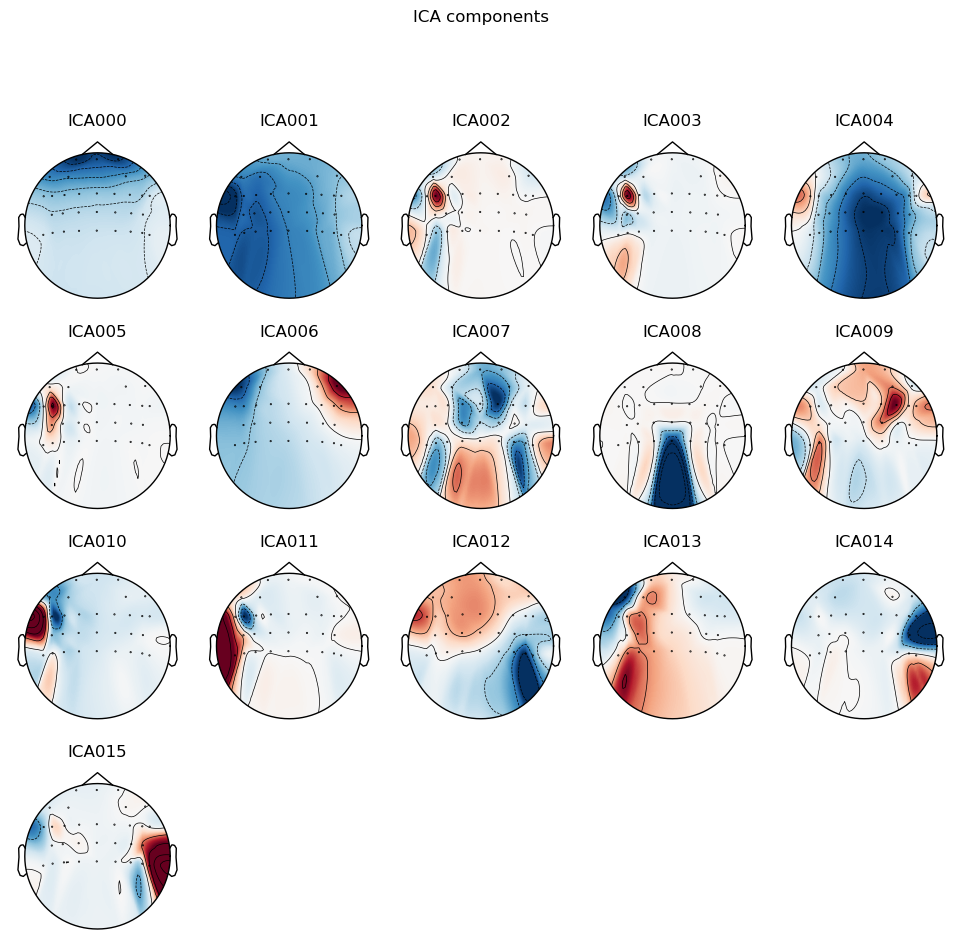

In [65]:
# Plot a topography map of the components
ica.plot_components()

In [66]:
# Plot the time courses of the source separation (sources in ICA does not mean brain sources)
ica.plot_sources(epochs, show_scrollbars=False)

In [67]:
# Plot the properties of particular components
components = [i for i in range(0, 16)]
ica.plot_properties(epochs,components)

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [68]:
# Exclude components
# ica.exclude = [0,4,5,7,9] # for epochs between -1 and 4
# ica.exclude = [0,2,5,6,7,9] # This is decided manuallyt after analyzing the components
ica.exclude = [0,6,7,8,9] # This is decided manuallyt after analyzing the components


In [69]:
#Apply ICA to the data
ica.apply(epochs)

Number of events,120
Events,MI_Left: 60MI_Right: 60
Time range,-2.000 – 6.000 s
Baseline,off


In [74]:
epochs.set_eeg_reference(ref_channels='average',projection=True)

Number of events,120
Events,MI_Left: 60MI_Right: 60
Time range,-2.000 – 6.000 s
Baseline,off


In [75]:
# raw.plot(events=events,event_id=event_id)
epochs.plot()

C:\Users\andresfs\AppData\Local\Temp\ipykernel_18268\2656434513.py:2: FutureWarning: The current default events=None is deprecated and will change to events=True in MNE 1.6. Set events=False to suppress this warning.
  epochs.plot()


In [76]:
epochs.drop_bad()

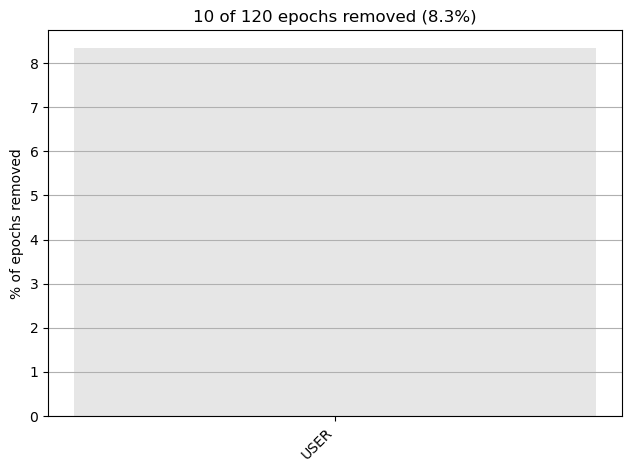

In [77]:
epochs.plot_drop_log()

In [120]:
channels = ['C3','C4']
epochs_TF_raw = epochs.copy().crop(tmin=-1,tmax=4).apply_proj().pick_channels(channels)

C:\Users\andresfs\AppData\Local\Temp\ipykernel_18268\1748653275.py:2: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  epochs_TF_raw = epochs.copy().crop(tmin=-1,tmax=4).apply_proj().pick_channels(channels)


In [121]:
freqs = np.arange(2, 35.5, 0.5)
n_cycles = freqs / 2.0  # different number of cycle per frequency
TF_mtaper = mne.time_frequency.tfr_multitaper(epochs_TF_raw['MI_Left','MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)

In [129]:
event_ids = ['MI_Right','MI_Left'] # events 
kwargs = dict(baseline=(-1,0), mode='percent', vmin=-1, vmax=1, fmin=None, fmax=None, cmap='jet')
figs1 = plot_TF_M(TF_mtaper, event_ids, **kwargs, comment='Multitaper - s' + str(1), reporting=True)

In [130]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
def plot_ERDX(tfr,channels,tmin=-1.5,tmax=3.5,baseline=(None,0),comment='', reporting=False, boundaries=[0,4,8,13,30,140]):

    # ERDS Plots 
    power_tfr = tfr.copy().crop(tmin,tmax).pick_channels(channels).apply_baseline(baseline=baseline, mode="percent") # apply baseline
    df = power_tfr.to_data_frame(time_format=None, long_format=True)

    # Map to frequency bands:
    freq_bounds = {"_": boundaries[0], "delta": boundaries[1], "theta": boundaries[2], "mu/alpha": boundaries[3], "beta": boundaries[4], "gamma": boundaries[5]}
    df["band"] = pd.cut(df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:])

    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = ["mu/alpha", "beta"]
    df = df[df.band.isin(freq_bands_of_interest)]
    df["band"] = df["band"].cat.remove_unused_categories()

    # Order channels for plotting:
    df["channel"] = df["channel"].cat.reorder_categories(("C3","C4"), ordered=True)

    g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
    g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
    axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)
    #g.set(ylim=(None, 1.5))
    g.set_axis_labels("Time (s)", "ERDS (%)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.add_legend(ncol=2, loc="lower center")
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
    g.fig.suptitle("ERDS" + comment)

    if reporting:
        return g

In [133]:
# Plot ERD per frequency bands
channels = ['C3','C4']
fig2 = plot_ERDX(TF_mtaper,channels, comment='raw - Multitapers - s' + str(1), reporting=True, boundaries=[0,4,10,15,30,140])


C:\Users\andresfs\AppData\Local\Temp\ipykernel_18268\3876003238.py:7: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.time_frequency.tfr.EpochsTFR'>.tmin (-1 s)
  power_tfr = tfr.copy().crop(tmin,tmax).pick_channels(channels).apply_baseline(baseline=baseline, mode="percent") # apply baseline
C:\Users\andresfs\AppData\Local\Temp\ipykernel_18268\3876003238.py:7: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  power_tfr = tfr.copy().crop(tmin,tmax).pick_channels(channels).apply_baseline(baseline=baseline, mode="percent") # apply baseline


In [134]:
report = mne.Report(title="Report Time-Frequency - Data Andres")
for fig in figs1:
        report.add_figure(fig=fig, title='ERDS', section='TF - ERDs Maps', tags='s'+str(1))
# Add to report
fig2.savefig('temp.png')
report.add_image(image='temp.png', title='ERDS mu/alpha & beta', section='TF - ERDs Maps', tags='s'+str(1))

# Save Report
report.save("Report - DataAndres.hdf5", overwrite=True)
report.save("Report - DataAndres.html", overwrite=True)

'C:\\Users\\andresfs\\Downloads\\Dataset MI - GigaScience\\Report - DataAndres.html'

#### Creating Epochs

In [ ]:
subjects = list(range(1, 53))

for subject in subjects:
    print('Processing Subject s' + str(subject))

    fname_mat = create_name(subject,'EEG_Data')

    # Convert .mat data to a raw object of MNE-python
    raw = data2mne(fname_mat, scale=1e-8)

    # Event ID definition
    event_id = {'Blink':1,'Up/Down':2,'Left/Right':3,'Jaw':4,'HeadMov':5, 'Resting':6, 'ME_Right':7, 'ME_Left':8, 'MI_Right':9, 'MI_Left':10}

    # Read events from Stimuli channel
    events = mne.find_events(raw, stim_channel='Stim', verbose=True,initial_event=True)

    # Plot Raw Data
    # raw.plot(events=events,event_id=event_id)

    # Only imaginary events
    event_id_MI = {'MI_Right':9, 'MI_Left':10}
    events_MI = events[events[:,2] > 8]

    # Change the custom montage to standard positions for better visualization
    biosemi64_montage = mne.channels.make_standard_montage('biosemi64')
    raw.set_montage(biosemi64_montage)

    # Create Epochs
    epochs = mne.Epochs(raw, events_MI, event_id_MI, tmin=-1.95, tmax=4.95, picks=('eeg'), baseline=None, preload=True)
    epochs.filter(0.5,None)

    # Common Average Reference as a projection
    epochs.set_eeg_reference(ref_channels='average',projection=True)

    # Plot Raw Data only with imaginary events
    # raw.plot(events=events_MI,event_id=event_id_M)

    # Electrode position 2D
    # raw.plot_sensors(kind='topomap',ch_type='eeg', show_names=True, sphere='eeglab')

    # Add epochs to the report
    report.add_epochs(epochs=epochs, title='Epochs - Highpass 0.5Hz', tags='s'+str(subject))

    # Prepare Epochs for TF
    channels = ['C3','C4']
    epochs_TF_raw = epochs.copy().apply_proj().pick_channels(channels)
    # epochs_TF_ASR = epochs_ASR.copy().apply_proj().pick_channels(channels)

    # Compute TF Maps - Wavelet
    freqs = np.arange(2, 35.5, 0.5)
    n_cycles = freqs / 2.0  # different number of cycle per frequency
    TF_raw_wav = mne.time_frequency.tfr_morlet(epochs_TF_raw['MI_Left','MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)
    # TF_ASR_wav = mne.time_frequency.tfr_morlet(epochs_TF_ASR['MI_Left','MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)

    # Compute TF Maps - Multitaper
    TF_raw_mtaper = mne.time_frequency.tfr_multitaper(epochs_TF_raw['MI_Left','MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)
    # TF_ASR_mtaper = mne.time_frequency.tfr_multitaper(epochs_TF_ASR['MI_Left','MI_Right'], freqs=freqs, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=3, n_jobs=4, average=False)

    # Plot TF Maps - Wavelet
    event_ids = ['MI_Right','MI_Left'] # events 
    kwargs = dict(baseline=(-1,0), mode='percent', vmin=-1.2, vmax=1.2, fmin=None, fmax=None, cmap='jet')
    figs1 = plot_TF_M(TF_raw_wav, event_ids, **kwargs, comment='raw - Wavelet - s' + str(subject), reporting=True)
    # figs2 = plot_TF_M(TF_ASR_wav, event_ids, **kwargs, comment='ASR - Wavelet - s' + str(subject), reporting=True)

    # Add to report
    for fig in figs1:
        report.add_figure(fig=fig, title='ERDS', section='TF - ERDs Maps', tags='s'+str(subject))
    # for fig in figs2:
    #     report.add_figure(fig=fig, title='ERDS', section='TF - ERDs Maps', tags='s'+str(subject))

    # Plot TF Maps - Multitaper
    figs1 = plot_TF_M(TF_raw_mtaper, event_ids, **kwargs, comment='raw - Multitaper - s' + str(subject), reporting=True)
    # figs2 = plot_TF_M(TF_ASR_mtaper, event_ids, **kwargs, comment='ASR - Multitaper - s' + str(subject), reporting=True)

    # Add to report
    for fig in figs1:
        report.add_figure(fig=fig, title='ERDS', section='TF - ERDs Maps', tags='s'+str(subject))
    # for fig in figs2:
    #     report.add_figure(fig=fig, title='ERDS', section='TF - ERDs Maps', tags='s'+str(subject))

    # Plot ERD per frequency bands
    channels = ['C3','C4']
    fig = plot_ERDs(TF_raw_mtaper,channels, comment='raw - Multitapers - s' + str(subject), reporting=True)

    # Add to report
    fig.savefig('temp.png')
    report.add_image(image='temp.png', title='ERDS mu/alpha & beta', section='TF - ERDs Maps', tags='s'+str(subject))

    # Plot ERD maps - Multitaper - Statistically significant
    # kwargs = dict(baseline=(-1,0), mode='percent', vmin=-1.2, vmax=1.2, cmap='jet')
    # figs1 = plot_TF_M_stat(TF_raw_mtaper.copy(), event_ids, **kwargs, comment='raw - Multitaper - s' + str(subject), reporting=True)
    # figs2 = plot_TF_M_stat(TF_ASR_mtaper.copy(), event_ids, **kwargs, comment='ASR - Multitaper - s' + str(subject), reporting=True)

    # Add to report
    # for fig in figs1:
    #     report.add_figure(fig=fig, title='Statistically Significant ERDS', section='TF - ERDs Maps', tags='s'+str(subject))
    # for fig in figs2:
    #     report.add_figure(fig=fig, title='ERDS', section='TF - ERDs Maps', tags='s'+str(subject))

    # Save Report
    report.save("Report - GigaScience.hdf5", overwrite=True)
    report.save("Report - GigaScience.html", overwrite=True)

    plt.close("all")



In [ ]:
epochs["MI_Right"].copy().apply_baseline().plot_image(picks=["C3", "C4"],vmin=-30, vmax=30)
epochs["MI_Left"].copy().apply_baseline().plot_image(picks=["C3", "C4"],vmin=-30, vmax=30)